### 2. First RNN: building the network

In [ ]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seeds for reproducibility
tf.random.set_seed(0)
np.random.seed(0)

In [ ]:
def plot_metrics(total_rewards, actor_losses, critic_losses, window_1=10, window_2=25):
    """
    Plots the raw metrics and their rolling statistics over windows of window_1 and window_2 episodes.

    Each column corresponds to one metric:
      - Column 1: Total Reward
      - Column 2: Actor Loss
      - Column 3: Critic Loss

    Row 1: Raw metrics.
    Row 2: Rolling mean, median, and std over a window of window_1 episodes.
    Row 3: Rolling mean, median, and std over a window of window_2 episodes.
    """

    # ------------------------------
    # Helper function: Rolling stats
    # ------------------------------
    def plot_rolling(ax, data, window, label):
        # Convert the list to a pandas Series.
        series = pd.Series(data)
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        rolling_median = series.rolling(window=window, min_periods=1).median()
        rolling_std = series.rolling(window=window, min_periods=1).std()

        # Plot the rolling mean and median.
        ax.plot(episodes, rolling_mean, label="Mean")
        ax.plot(episodes, rolling_median, label="Median")
        # Plot an error band representing +/- the rolling std.
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std,
                        alpha=0.2, label="Std")
        ax.set_title(f"Rolling (window={window}) {label}")
        ax.set_xlabel("Episode")
        ax.legend()

    episodes = range(1, len(total_rewards) + 1)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))

    # ------------------------------
    # Raw metrics
    # ------------------------------

    # Total Reward
    axs[0, 0].plot(episodes, total_rewards, label="Raw")
    axs[0, 0].set_title("Raw Total Reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].legend()

    # Actor Loss
    axs[0, 1].plot(episodes, actor_losses, label="Raw", color="tab:orange")
    axs[0, 1].set_title("Raw Actor Loss")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Actor Loss")
    axs[0, 1].legend()

    # Critic Loss
    axs[0, 2].plot(episodes, critic_losses, label="Raw", color="tab:green")
    axs[0, 2].set_title("Raw Critic Loss")
    axs[0, 2].set_xlabel("Episode")
    axs[0, 2].set_ylabel("Critic Loss")
    axs[0, 2].legend()

    # ------------------------------
    # Rolling stats with window=window_1
    # ------------------------------
    plot_rolling(axs[1, 0], total_rewards, window_1, "Total Reward")
    plot_rolling(axs[1, 1], actor_losses, window_1, "Actor Loss")
    plot_rolling(axs[1, 2], critic_losses, window_1, "Critic Loss")

    # ------------------------------
    # Rolling stats with window=window_2
    # ------------------------------
    plot_rolling(axs[2, 0], total_rewards, window_2, "Total Reward")
    plot_rolling(axs[2, 1], actor_losses, window_2, "Actor Loss")
    plot_rolling(axs[2, 2], critic_losses, window_2, "Critic Loss")

    plt.tight_layout()
    plt.show()

#### 2.1. Environment

We will be using a Gymnasium environment called CartPole. The CartPole environment is a classic control benchmark in reinforcement learning. In this simulation, a cart moves along a frictionless track, and a pole is attached to the cart by a hinge. The goal is to keep the pole balanced upright by applying forces (actions) to the cart.

* **State (Observations)**: the environment returns a state that is typically a 4-dimensional vector

    * Cart Position: The horizontal position of the cart on the track.

    * Cart Velocity: The speed at which the cart is moving.

    * Pole Angle: The angle of the pole with respect to the vertical.

    * Pole Angular Velocity: The rate at which the pole is rotating.

* **Actions**: the action space is discrete with two possible actions

    * Action 0: Push the cart to the left.

    * Action 1: Push the cart to the right.

* **Rewards**: at each time step, the agent receives a reward (typically +1) as long as the pole remains upright and the cart stays within a defined range. Once the pole falls beyond a certain angle or the cart moves too far off the track, the episode ends (i.e., the environment signals termination).

* **Episode Termination**: an episode ends when

    * The pole’s angle exceeds a threshold (i.e., it falls too far from vertical).

    * The cart moves out of the allowed bounds on the track.

    * The maximum allowed time steps are reached.

#### 2.2 Actor and Critic networks

The networks we are using are RNN with GRU units. We will create two different networks: actor (policy) network that takes as inputs the state and returns some actions and critic (value) network which takes as inputs the state and returns the reward expected given an action.

**Shape of the networks**:
* Actor (policy) network:
    * Input: tensor of states (shape `batch_size, time_steps, input_dim`)
    * Output: vector of action probabilities (shape `batch_size, output_dim=2`)
* Critic (value) network:
    * Input: tensor of states (shape `batch_size, time_steps, input_dim`)
    * Output: scalar of value estimation (shape `batch_size, 1`)
    
**Hidden layers**:

The networks use GRU hidden layers to process the temporal sequence and produce an output for every time step. We need to set the density of the connections between layers (connection probability of 0.1 for actor and 1 for critic).

**GRU units**:

A GRU cell is a type of recurrent neural unit that maintains a hidden state across time steps.

* Gates:

    * Update Gate: controls how much of the previous hidden state to keep.
    * Reset Gate: determines how to combine the new input with the previous hidden state.

    The candidate hidden state is computed from the current input and the previous state, and then the update gate decides the final new state.

* Recurrence: the layers are used sequentially. The hidden state from onte time step (or one layer) is carried over to the next time step (or layer).

* Activation functions: we need to select threshold-linear functions or rectified linear instead of sigmoid or hyperbolic tangent activation functions for the hidden layers.

* Firing rate: we need to also include a gate to measure the firing rate of the neurons (not yet implemented)

**Agent**: the agent that takes the actions is the combination of the actor network and the critic network. This agent takes the actions and evaluate them, to learn from the actions taken and the environment

In [ ]:
# --------------------------
# Actor (Policy) Network
# --------------------------

class ActorModel(Model):
    # Initialize model
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 num_layers=1,
                 noisy_input=False,
                 noise_std=0.0,
                 activation_func=tf.nn.relu,
                 connection_prob=0.1):
        """
        Actor network that uses GRU layers to output action probabilities.
        Args:
            input_size (int): Dimensionality of the observations (states).
            hidden_size (int): Number of GRU units.
            output_size (int): Number of actions.
            num_layers (int): Number of GRU layers.
            noisy_input (bool): Whether to add Gaussian noise to inputs.
            noise_std (float): Standard deviation of the input noise.
            activation_func (function): Activation function for GRU candidate (default: ReLU).
            connection_prob (float): Probability that a connection is active (default: 0.1 for actor).
        """

        super(ActorModel, self).__init__()
        self.noisy_input = noisy_input
        self.noise_std = noise_std
        self.activation_func = activation_func
        self.connection_prob = connection_prob
        self.num_layers = num_layers

        # Build the GRU layers (recurrent)
        self.gru_layers = []
        for i in range(num_layers):
            # GRU construction (retrun hidden states for firing rate)
            self.gru_layers.append(layers.GRU(hidden_size,
                                              activation=self.activation_func,
                                              recurrent_activation=tf.nn.sigmoid,
                                              return_sequences=True,
                                              return_state=True))

        # Build fixed masks for each GRU layer
        self.masks = []
        for i in range(num_layers):
            if connection_prob < 1.0:
                mask = tf.cast(tf.random.uniform((1, 1, hidden_size)) < connection_prob, tf.float32)
            else:
                mask = tf.ones((1, 1, hidden_size), dtype=tf.float32)
            self.masks.append(mask)

        # Final dense layer
        self.fc = layers.Dense(output_size)

    # Forward pass
    def call(self, inputs, hidden_states=None):

        # Generate noisy input if it is specified
        if self.noisy_input is True:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.noise_std)
            inputs = inputs + noise

        # Variables initialization (pass the output as the input to the next layer)
        output = inputs
        new_states = []

        # Loop through GRU layers
        for i, gru in enumerate(self.gru_layers):

            # Use hidden state as initial state. Final state added to new_states
            output, state = gru(output, initial_state=hidden_states)
            new_states.append(state)

            # Apply connectivity mask
            output = output * self.masks[i]

        # Use the output at the last time step for action logits
        logits = self.fc(output[:, -1, :])

        # Probability of taking each action
        probs = tf.nn.softmax(logits, axis=-1)
        return probs, new_states

# --------------------------
# Critic (Value) Network
# --------------------------

class CriticModel(Model):
    # Initialize model
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 noisy_input=False,
                 noise_std=0.0,
                 activation_func=tf.nn.relu,
                 connection_prob=1.0):
        """
        Critic network that uses GRU layers to output a scalar value estimate.
        Args:
            input_size (int): Dimensionality of the observations.
            hidden_size (int): Number of GRU units.
            num_layers (int): Number of GRU layers.
            noisy_input (bool): Whether to add Gaussian noise to inputs.
            noise_std (float): Standard deviation of the input noise.
            activation_func (function): Activation function for GRU candidate (default: ReLU).
            connection_prob (float): Probability that a connection is active (default: 1.0 for critic).
        """

        super(CriticModel, self).__init__()
        self.noisy_input = noisy_input
        self.noise_std = noise_std
        self.activation_func = activation_func
        self.conn_prob = connection_prob
        self.num_layers = num_layers

        # Build the GRU layers (recurrent)
        self.gru_layers = []
        for i in range(num_layers):
            # GRU construction
            self.gru_layers.append(layers.GRU(hidden_size,
                                              activation=self.activation_func,
                                              recurrent_activation=tf.nn.sigmoid,
                                              return_sequences=True,
                                              return_state=True))

        # Build fixed masks for each GRU layer
        self.masks = []
        for i in range(num_layers):
            if connection_prob < 1.0:
                mask = tf.cast(tf.random.uniform((1, 1, hidden_size)) < connection_prob, tf.float32)
            else:
                mask = tf.ones((1, 1, hidden_size), dtype=tf.float32)
            self.masks.append(mask)

        # Final dense layer
        self.fc = layers.Dense(1)

    # Forward pass
    def call(self, inputs, hidden_states=None):

        # Generate noisy input when training (and if it is specified)
        if self.noisy_input is True:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.noise_std)
            inputs = inputs + noise

        # Variables initialization
        output = inputs
        new_states = []

        # Loop through GRU layers
        for i, gru in enumerate(self.gru_layers):

            # Final state appended to new_states
            output, state = gru(output, initial_state=hidden_states)
            new_states.append(state)

            # Apply connectivity mask
            output = output * self.masks[i]

        # Use the last time step for value prediction
        value = self.fc(output[:, -1, :])
        return value, new_states

In [ ]:
# --------------------------
# Actor-Critic Agent
# --------------------------
class ActorCriticAgent:
    def __init__(self,
                 obs_size,
                 act_size,
                 actor_hidden_size=128,
                 critic_hidden_size=128,
                 actor_layers=1,
                 critic_layers=1,
                 noisy_input=False,
                 noise_std=0.0,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 activation_func=tf.nn.relu,
                 actor_connection_prob=0.1,
                 critic_connection_prob=1.0):
        """
        Container for the actor and critic networks and their optimizers.
        Args:
            obs_size (int): Dimension of observations.
            act_size (int): Number of actions.
            actor_hidden_size (int): Number of hidden units in the actor GRU.
            critic_hidden_size (int): Number of hidden units in the critic GRU.
            actor_layers (int): Number of GRU layers in the actor.
            critic_layers (int): Number of GRU layers in the critic.
            noisy_input (bool): If True, add noise to inputs.
            noise_std (float): Standard deviation for input noise.
            actor_lr (float): Learning rate for the actor.
            critic_lr (float): Learning rate for the critic.
            activation_func (function): Activation function for GRU candidate (default: ReLU).
            actor_connection_prob (float): Probability that a connection is active for the actor.
            critic_connection_prob (float): Probability that a connection is active for the critic.
        """
        self.actor = ActorModel(
            input_size=obs_size,
            hidden_size=actor_hidden_size,
            output_size=act_size,
            num_layers=actor_layers,
            noisy_input=noisy_input,
            noise_std=noise_std,
            activation_func=activation_func,
            connection_prob=actor_connection_prob
        )
        self.critic = CriticModel(
            input_size=obs_size,
            hidden_size=critic_hidden_size,
            num_layers=critic_layers,
            noisy_input=noisy_input,
            noise_std=noise_std,
            activation_func=activation_func,
            connection_prob=critic_connection_prob
        )
        self.actor_optimizer = optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = optimizers.Adam(learning_rate=critic_lr)

    def select_action(self, state, actor_hidden_states=None, training=True):
        """
        Selects an action based on the actor network.
        Args:
            state (np.array): Current observation (1D array).
            actor_hidden_states: Hidden states for the actor GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            action (int): Selected action.
            log_prob (tf.Tensor): Log probability of the selected action.
            new_actor_hidden_states: Updated hidden states for the actor.
        """

        # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)

        # Pass the state through the actor network
        probs, new_actor_hidden_states = self.actor(state_tensor, hidden_states=actor_hidden_states, training=training)

        # Sample an action from the probability distribution
        action = tf.random.categorical(tf.math.log(probs), num_samples=1)
        action = tf.squeeze(action, axis=-1)

        # Calculate log probability of the selected action
        action_one_hot = tf.one_hot(action, depth=probs.shape[-1])
        log_prob = tf.math.log(tf.reduce_sum(probs * action_one_hot, axis=-1))

        # Return the action as an integer, the log probability, and the updated hidden states
        return int(action[0].numpy()), log_prob, new_actor_hidden_states

    def evaluate_state(self, state, critic_hidden_states=None, training=True):
        """
        Evaluates the state value using the critic network.
        Args:
            state (np.array): Current observation.
            critic_hidden_states: Hidden state(s) for the critic GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            value (tf.Tensor): Estimated state value.
            new_critic_hidden_states: Updated hidden state(s) for the critic.
        """

        # Convert state into a 3D tensor of shape (1, 1, input_dim)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)

        # Pass through the critic network
        value, new_critic_hidden_states = self.critic(state_tensor, hidden_states=critic_hidden_states, training=training)
        # value has shape (1, 1), so extract the scalar using [0, 0]
        return value[0, 0], new_critic_hidden_states

#### 2.3. Training the networks: REINFORCE Algorithm

Once the networks are built, we set the training loop. The algorithm for training them is the REINFORCE algorithm. We will relate each step with the mathematical formulation.

Loop forever (for each episode):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $I \leftarrow 1$ (initialize episode)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Loop while $S$ is not terminal (for each time step):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $A \sim \pi (\cdot | S, \theta)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Take action $A$, observe $S', R$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\delta \leftarrow R + \gamma \hat{v} (S', w) - \hat{v}(S, w)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow w + \alpha^w \delta \nabla \hat{v}(S,w)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (if $S'$ is terminal, then $\hat{v}(S',w)=0$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta \leftarrow \theta + \alpha^{\theta} I \delta \nabla ln \pi(A | S, \theta)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $I \leftarrow \gamma I$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $S \leftarrow S'$

In [ ]:
# --------------------------
# Helper function: Discount rewards
# --------------------------
def discount_rewards(rewards, gamma):
    discounted = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted.insert(0, R)
    return discounted

# --------------------------
# Training using REINFORCE with baseline
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[log(pi(a|s)) * (R - V(s))]
         and critic using:
            L_critic = E[(R - V(s))^2]
    """

    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    # Loop forever (for each episode)
    for episode in range(1, num_episodes + 1):

        # Initialize episode
        state, _ = env.reset()
        done = False

        states = []
        actions = []
        rewards = []

        actor_hidden_states = None
        critic_hidden_states = None

        # Loop while state is not terminal (for each time step)
        while not done:

            # Take action given the actor network
            action, _, _ = agent.select_action(state, actor_hidden_states, training=True)

            # Observe S', R
            next_state, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # Compute discounted returns and convert to tensor
        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        # --- Actor update ---
        with tf.GradientTape() as tape_actor:
            log_probs = []
            # Initialize hidden state
            actor_hidden_state = None

            # Actor forward pass for each state to compute log probabilities
            for s, a in zip(states, actions):
                # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)

                # Take action given the actor network (get probabilities)
                probs, actor_hidden_state = agent.actor(s_tensor, hidden_states=actor_hidden_state, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1))
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            # Critic evaluation for advantage (delta)
            critic_hidden_state = None
            values = []
            for s in states:
                # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)

                # Value estimation given the critic network
                value, critic_hidden_state = agent.critic(s_tensor, hidden_states=critic_hidden_state, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)

            # Advantage
            advantage = returns - values

            # Loss function
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))

        # Compute gradients and update actor network parameters
        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        # --- Critic Update ---
        with tf.GradientTape() as tape_critic:
            critic_hidden_state = None
            values = []
            for s in states:
                # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)

                # Value estimation given the critic network
                value, critic_hidden_state = agent.critic(s_tensor, hidden_states=critic_hidden_state, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)

            # Loss function
            critic_loss = tf.reduce_mean(tf.square(returns - values))

        # Compute gradients and update critic network parameters
        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        # Progress report
        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\tActor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

        # Record metrics
        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

    # Return the training metrics
    return total_rewards_history, actor_loss_history, critic_loss_history

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # Configuration parameters
    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "noisy_input": True,
        "noise_std": 0.05,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 500,
        "gamma": 0.99,
        "activation_func": tf.nn.relu,
        "actor_connection_prob": 0.1,
        "critic_connection_prob": 1.0
    }

    # Initialize agent with the configuration
    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        noisy_input=config["noisy_input"],
        noise_std=config["noise_std"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        activation_func=config["activation_func"],
        actor_connection_prob=config["actor_connection_prob"],
        critic_connection_prob=config["critic_connection_prob"]
    )

    # Start training
    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(env,
                                                                                 agent,
                                                                                 num_episodes=config["num_episodes"],
                                                                                 gamma=config["gamma"])

Episode 10	Total Reward: 22.00	Actor Loss: 7.3139	Critic Loss: 144.3893
Episode 20	Total Reward: 23.00	Actor Loss: 7.4131	Critic Loss: 148.6309
Episode 30	Total Reward: 9.00	Actor Loss: 2.2391	Critic Loss: 23.5629
Episode 40	Total Reward: 20.00	Actor Loss: 5.8015	Critic Loss: 103.2008
Episode 50	Total Reward: 21.00	Actor Loss: 5.7653	Critic Loss: 107.2680
Episode 60	Total Reward: 10.00	Actor Loss: 2.0807	Critic Loss: 24.7723
Episode 70	Total Reward: 24.00	Actor Loss: 4.9100	Critic Loss: 116.9392
Episode 80	Total Reward: 28.00	Actor Loss: 3.9708	Critic Loss: 147.6106
Episode 90	Total Reward: 12.00	Actor Loss: 1.9804	Critic Loss: 30.7384
Episode 100	Total Reward: 25.00	Actor Loss: 4.0689	Critic Loss: 106.9199
Episode 110	Total Reward: 9.00	Actor Loss: 0.3328	Critic Loss: 21.4258
Episode 120	Total Reward: 27.00	Actor Loss: 3.2824	Critic Loss: 111.8003
Episode 130	Total Reward: 25.00	Actor Loss: 3.9248	Critic Loss: 96.9777
Episode 140	Total Reward: 39.00	Actor Loss: 7.4246	Critic Loss: 223

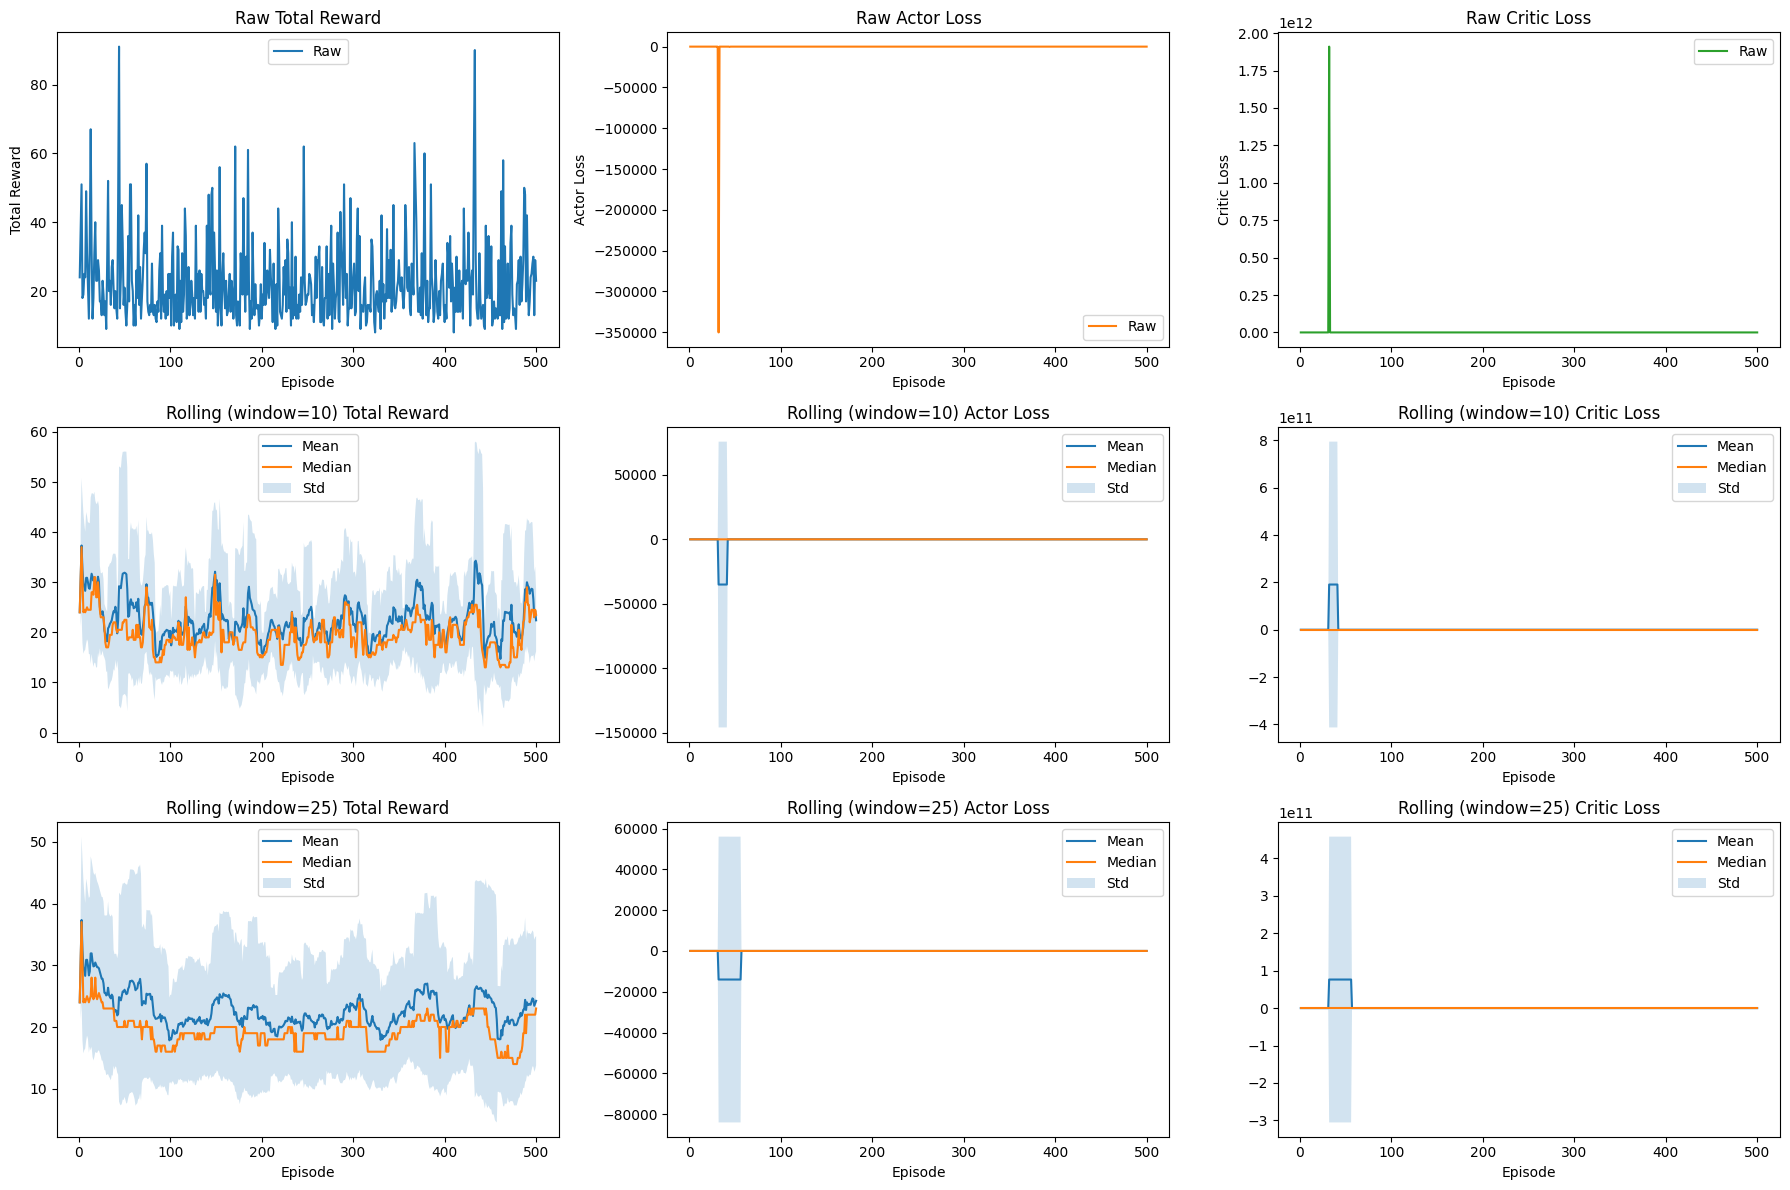

In [ ]:
plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

#### 2.4. Hyperparameters search

The results are awful, let us get better results with hyperparameters. Then, we may add regularization, clipping, normalization of the reward and exploration incentives to improve even more the results.

In [ ]:
# --------------------------
# Grid Search Function
# --------------------------
def grid_search():
    # Define the hyperparameter grids:
    lr_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
    gamma_list = [0.90, 0.95, 0.99]

    results = []

    # Loop over all combinations
    for lr in lr_list:
      for gamma in gamma_list:
        print(f"\nTraining with learning_rate={lr}, gamma={gamma}")
        # Configuration (with fixed noisy_input=False)
        config = {
            "actor_hidden_size": 128,
            "critic_hidden_size": 128,
            "actor_layers": 1,
            "critic_layers": 1,
            "noisy_input": False,
            "noise_std": 0.05,
            "actor_lr": lr,
            "critic_lr": lr,
            "num_episodes": 250,
            "gamma": gamma,
            "activation_func": tf.nn.relu,
            "actor_connection_prob": 0.1,
            "critic_connection_prob": 1.0
            }

        # Create environment and agent
        env = gym.make("CartPole-v1")
        agent = ActorCriticAgent(
            obs_size=env.observation_space.shape[0],
            act_size=env.action_space.n,
            actor_hidden_size=config["actor_hidden_size"],
            critic_hidden_size=config["critic_hidden_size"],
            actor_layers=config["actor_layers"],
            critic_layers=config["critic_layers"],
            noisy_input=config["noisy_input"],
            noise_std=config["noise_std"],
            actor_lr=config["actor_lr"],
            critic_lr=config["critic_lr"],
            activation_func=config["activation_func"],
            actor_connection_prob=config["actor_connection_prob"],
            critic_connection_prob=config["critic_connection_prob"],
            )
        # Train for 250 episodes
        tot_rewards, act_losses, crit_losses = train_agent(env, agent, num_episodes=250, gamma=gamma, print_interval=50)

        # Compute aggregate metrics
        result = {
            "actor_lr": lr,
            "critic_lr": lr,
            "gamma": gamma,
            "mean_reward": np.mean(tot_rewards),
            "median_reward": np.median(tot_rewards),
            "max_reward": np.max(tot_rewards),
            "mean_actor_loss": np.mean(act_losses),
            "median_actor_loss": np.median(act_losses),
            "max_actor_loss": np.max(act_losses),
            "mean_critic_loss": np.mean(crit_losses),
            "median_critic_loss": np.median(crit_losses),
            "max_critic_loss": np.max(crit_losses)
            }

        results.append(result)

    df_results = pd.DataFrame(results)
    print("\nGrid Search Results:")
    print(df_results)

# --------------------------
# Main: Run Grid Search
# --------------------------
if __name__ == '__main__':
    grid_search()


Training with learning_rate=0.0001, gamma=0.9
Episode 50	Total Reward: 21.00	Actor Loss: 4.2054	Critic Loss: 42.7182
Episode 100	Total Reward: 13.00	Actor Loss: 3.1515	Critic Loss: 25.1188
Episode 150	Total Reward: 12.00	Actor Loss: 2.8951	Critic Loss: 21.5022
Episode 200	Total Reward: 9.00	Actor Loss: 2.2295	Critic Loss: 14.4545
Episode 250	Total Reward: 17.00	Actor Loss: 3.2984	Critic Loss: 29.5188

Training with learning_rate=0.0001, gamma=0.95
Episode 50	Total Reward: 24.00	Actor Loss: 5.9860	Critic Loss: 90.9785
Episode 100	Total Reward: 32.00	Actor Loss: 7.0827	Critic Loss: 123.5211
Episode 150	Total Reward: 33.00	Actor Loss: 6.9809	Critic Loss: 121.2705
Episode 200	Total Reward: 16.00	Actor Loss: 3.7692	Critic Loss: 44.4781
Episode 250	Total Reward: 16.00	Actor Loss: 3.8575	Critic Loss: 46.1634

Training with learning_rate=0.0001, gamma=0.99
Episode 50	Total Reward: 28.00	Actor Loss: 9.0889	Critic Loss: 222.4605
Episode 100	Total Reward: 20.00	Actor Loss: 6.6921	Critic Loss: 12

The results are still very bad, the network do not learn anything. As there is no releveant hyperparameter, we will use the ones we have been trying. Now let us focus on other strategies.


#### 2.5. Regularization

Let us add $L_2$ regularization terms to see if the results improve.

In [ ]:
# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor = 1e-4, l2_critic = 1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """

    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    # Regularization coefficients for actor and critic.
    lambda_actor = l2_actor
    lambda_critic = l2_critic

    # Loop for each episode.
    for episode in range(1, num_episodes + 1):

        # Initialize episode.
        state, _ = env.reset()
        done = False

        states = []
        actions = []
        rewards = []

        actor_hidden_states = None
        critic_hidden_states = None

        # Collect trajectory.
        while not done:
            # Take action using the actor network.
            action, _, _ = agent.select_action(state, actor_hidden_states, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # Compute discounted returns and convert to tensor.
        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        # --- Actor update ---
        with tf.GradientTape() as tape_actor:
            log_probs = []
            actor_hidden_state = None

            # Re-run actor forward pass for each state.
            for s, a in zip(states, actions):
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)  # shape: (1, input_dim)
                s_tensor = tf.expand_dims(s_tensor, axis=1)   # shape: (1, 1, input_dim)
                probs, actor_hidden_state = agent.actor(s_tensor, hidden_states=actor_hidden_state, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            # Re-run critic forward pass for advantage computation.
            critic_hidden_state = None
            values = []
            for s in states:
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, critic_hidden_state = agent.critic(s_tensor, hidden_states=critic_hidden_state, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            advantage = returns - values

            # Standard actor loss.
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))
            # L2 regularization on actor weights.
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

        # Compute gradients and update actor parameters.
        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        # --- Critic update ---
        with tf.GradientTape() as tape_critic:
            critic_hidden_state = None
            values = []
            for s in states:
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, critic_hidden_state = agent.critic(s_tensor, hidden_states=critic_hidden_state, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            critic_loss = tf.reduce_mean(tf.square(returns - values))
            # L2 regularization on critic weights.
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        # Compute gradients and update critic parameters.
        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        # Progress report.
        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

        # Record metrics.
        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

    # Return the training metrics.
    return total_rewards_history, actor_loss_history, critic_loss_history

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # Configuration parameters
    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "noisy_input": True,
        "noise_std": 0.05,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 500,
        "gamma": 0.99,
        "activation_func": tf.nn.relu,
        "actor_connection_prob": 0.1,
        "critic_connection_prob": 1.0
    }

    # Initialize agent with the configuration
    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        noisy_input=config["noisy_input"],
        noise_std=config["noise_std"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        activation_func=config["activation_func"],
        actor_connection_prob=config["actor_connection_prob"],
        critic_connection_prob=config["critic_connection_prob"]
    )

    # Start training
    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(env,
                                                                                 agent,
                                                                                 num_episodes=config["num_episodes"],
                                                                                 gamma=config["gamma"])

Episode 10	Total Reward: 13.00	Actor Loss: 4.4887	Critic Loss: 54.9335
Episode 20	Total Reward: 15.00	Actor Loss: 4.8602	Critic Loss: 67.1331
Episode 30	Total Reward: 16.00	Actor Loss: 4.6142	Critic Loss: 69.6271
Episode 40	Total Reward: 28.00	Actor Loss: 8.4637	Critic Loss: 201.9961
Episode 50	Total Reward: 21.00	Actor Loss: 6.5666	Critic Loss: 122.2400
Episode 60	Total Reward: 25.00	Actor Loss: 7.5586	Critic Loss: 163.9003
Episode 70	Total Reward: 33.00	Actor Loss: 9.8319	Critic Loss: 269.0818
Episode 80	Total Reward: 18.00	Actor Loss: 5.0671	Critic Loss: 85.6840
Episode 90	Total Reward: 27.00	Actor Loss: 8.0764	Critic Loss: 188.0791
Episode 100	Total Reward: 19.00	Actor Loss: 5.9327	Critic Loss: 101.5871
Episode 110	Total Reward: 12.00	Actor Loss: 3.9291	Critic Loss: 42.6767
Episode 120	Total Reward: 24.00	Actor Loss: 7.6158	Critic Loss: 157.0449
Episode 130	Total Reward: 35.00	Actor Loss: 10.3375	Critic Loss: 309.0933
Episode 140	Total Reward: 21.00	Actor Loss: 5.5340	Critic Loss: 

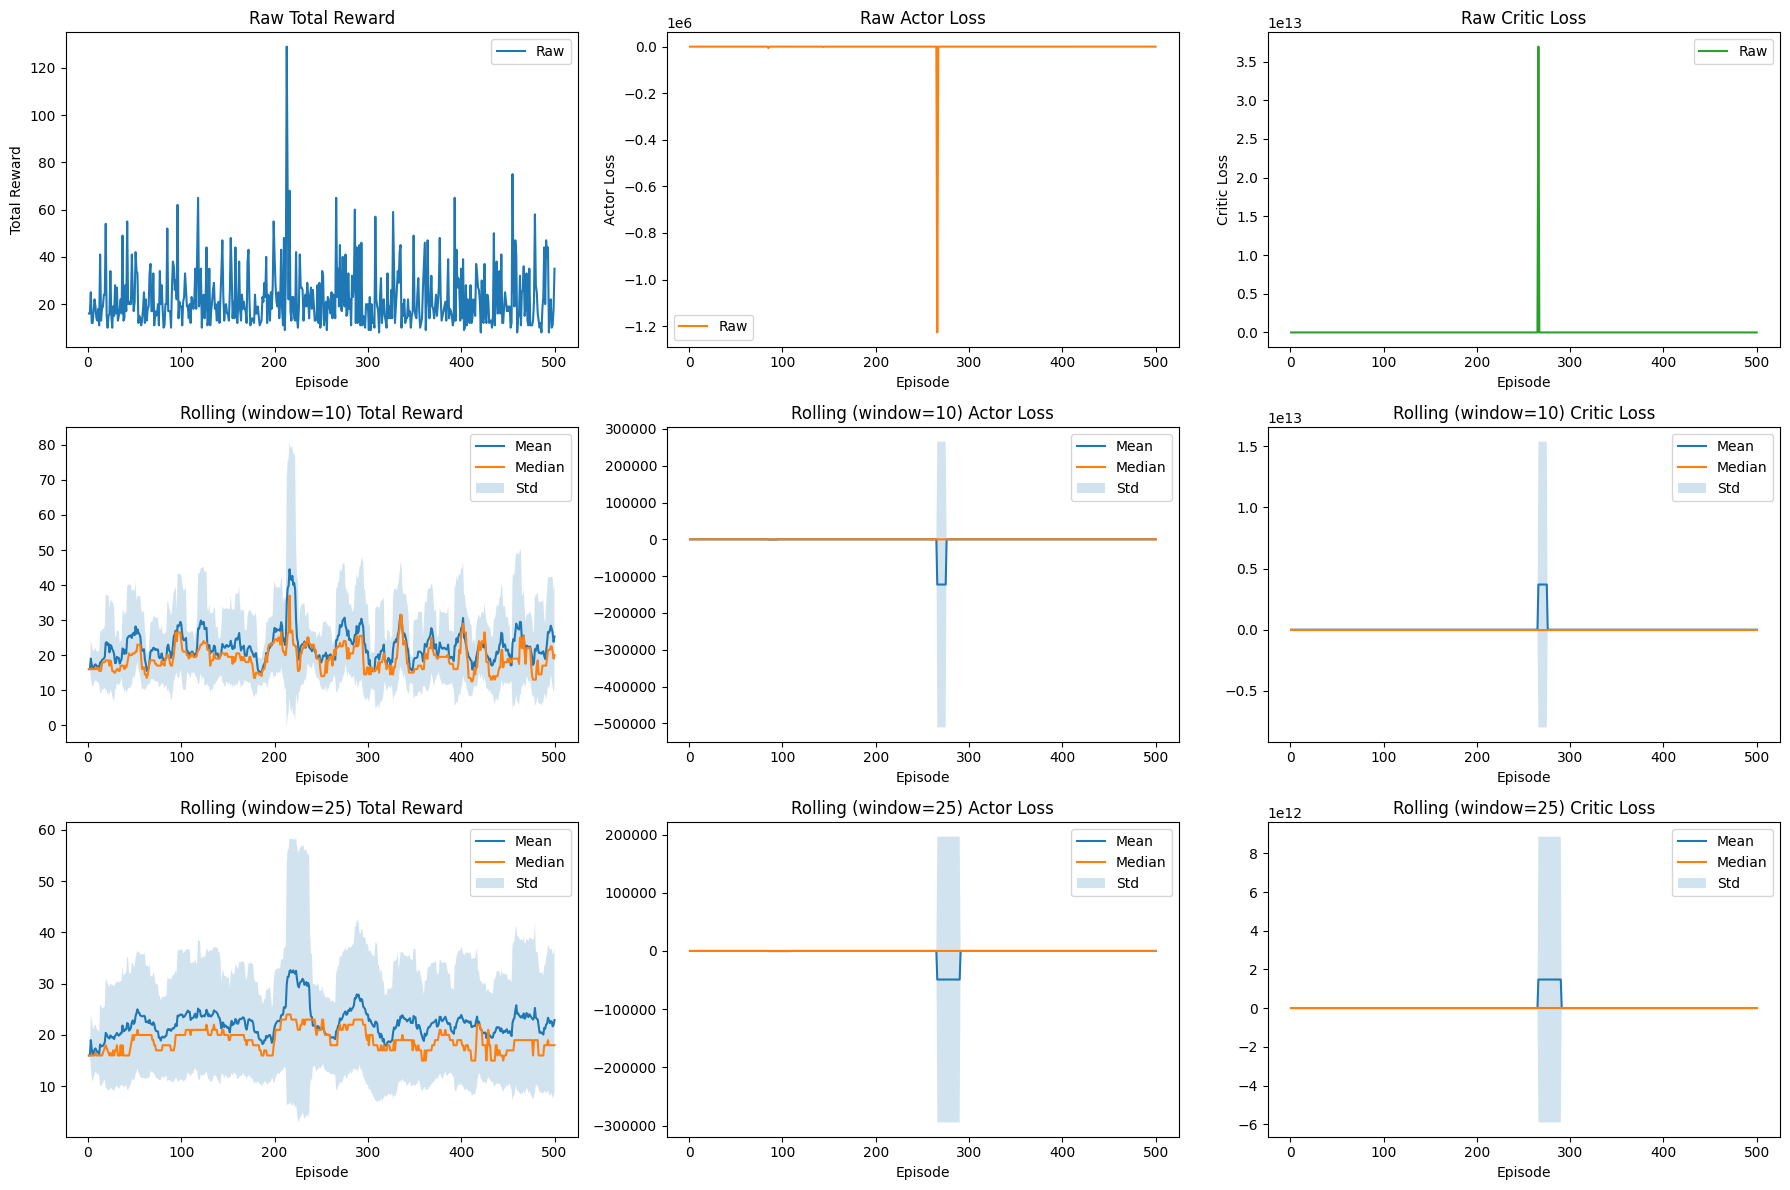

In [ ]:
plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # Configuration parameters
    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "noisy_input": False,
        "noise_std": 0.05,
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 1000,
        "gamma": 0.99,
        "activation_func": tf.nn.relu,
        "actor_connection_prob": 0.1,
        "critic_connection_prob": 1.0
    }

    # Initialize agent with the configuration
    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        noisy_input=config["noisy_input"],
        noise_std=config["noise_std"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        activation_func=config["activation_func"],
        actor_connection_prob=config["actor_connection_prob"],
        critic_connection_prob=config["critic_connection_prob"]
    )

    # Start training
    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(env,
                                                                                 agent,
                                                                                 num_episodes=config["num_episodes"],
                                                                                 gamma=config["gamma"],
                                                                                 l2_actor = 0.001,
                                                                                 l2_critic = 0.001)

Episode 10	Total Reward: 68.00	Actor Loss: 19.2451	Critic Loss: 976.1368
Episode 20	Total Reward: 14.00	Actor Loss: 4.9375	Critic Loss: 64.4761
Episode 30	Total Reward: 26.00	Actor Loss: 8.6733	Critic Loss: 196.9990
Episode 40	Total Reward: 34.00	Actor Loss: 10.8731	Critic Loss: 312.6292
Episode 50	Total Reward: 50.00	Actor Loss: 15.1298	Critic Loss: 596.8643
Episode 60	Total Reward: 15.00	Actor Loss: 5.2244	Critic Loss: 72.8732
Episode 70	Total Reward: 18.00	Actor Loss: 6.0443	Critic Loss: 100.5644
Episode 80	Total Reward: 21.00	Actor Loss: 7.0523	Critic Loss: 132.9991
Episode 90	Total Reward: 20.00	Actor Loss: 6.7520	Critic Loss: 121.5088
Episode 100	Total Reward: 29.00	Actor Loss: 9.4090	Critic Loss: 233.4718
Episode 110	Total Reward: 13.00	Actor Loss: 4.4946	Critic Loss: 54.9588
Episode 120	Total Reward: 19.00	Actor Loss: 6.3082	Critic Loss: 108.4697
Episode 130	Total Reward: 16.00	Actor Loss: 5.3691	Critic Loss: 78.5677
Episode 140	Total Reward: 13.00	Actor Loss: 4.3832	Critic Los

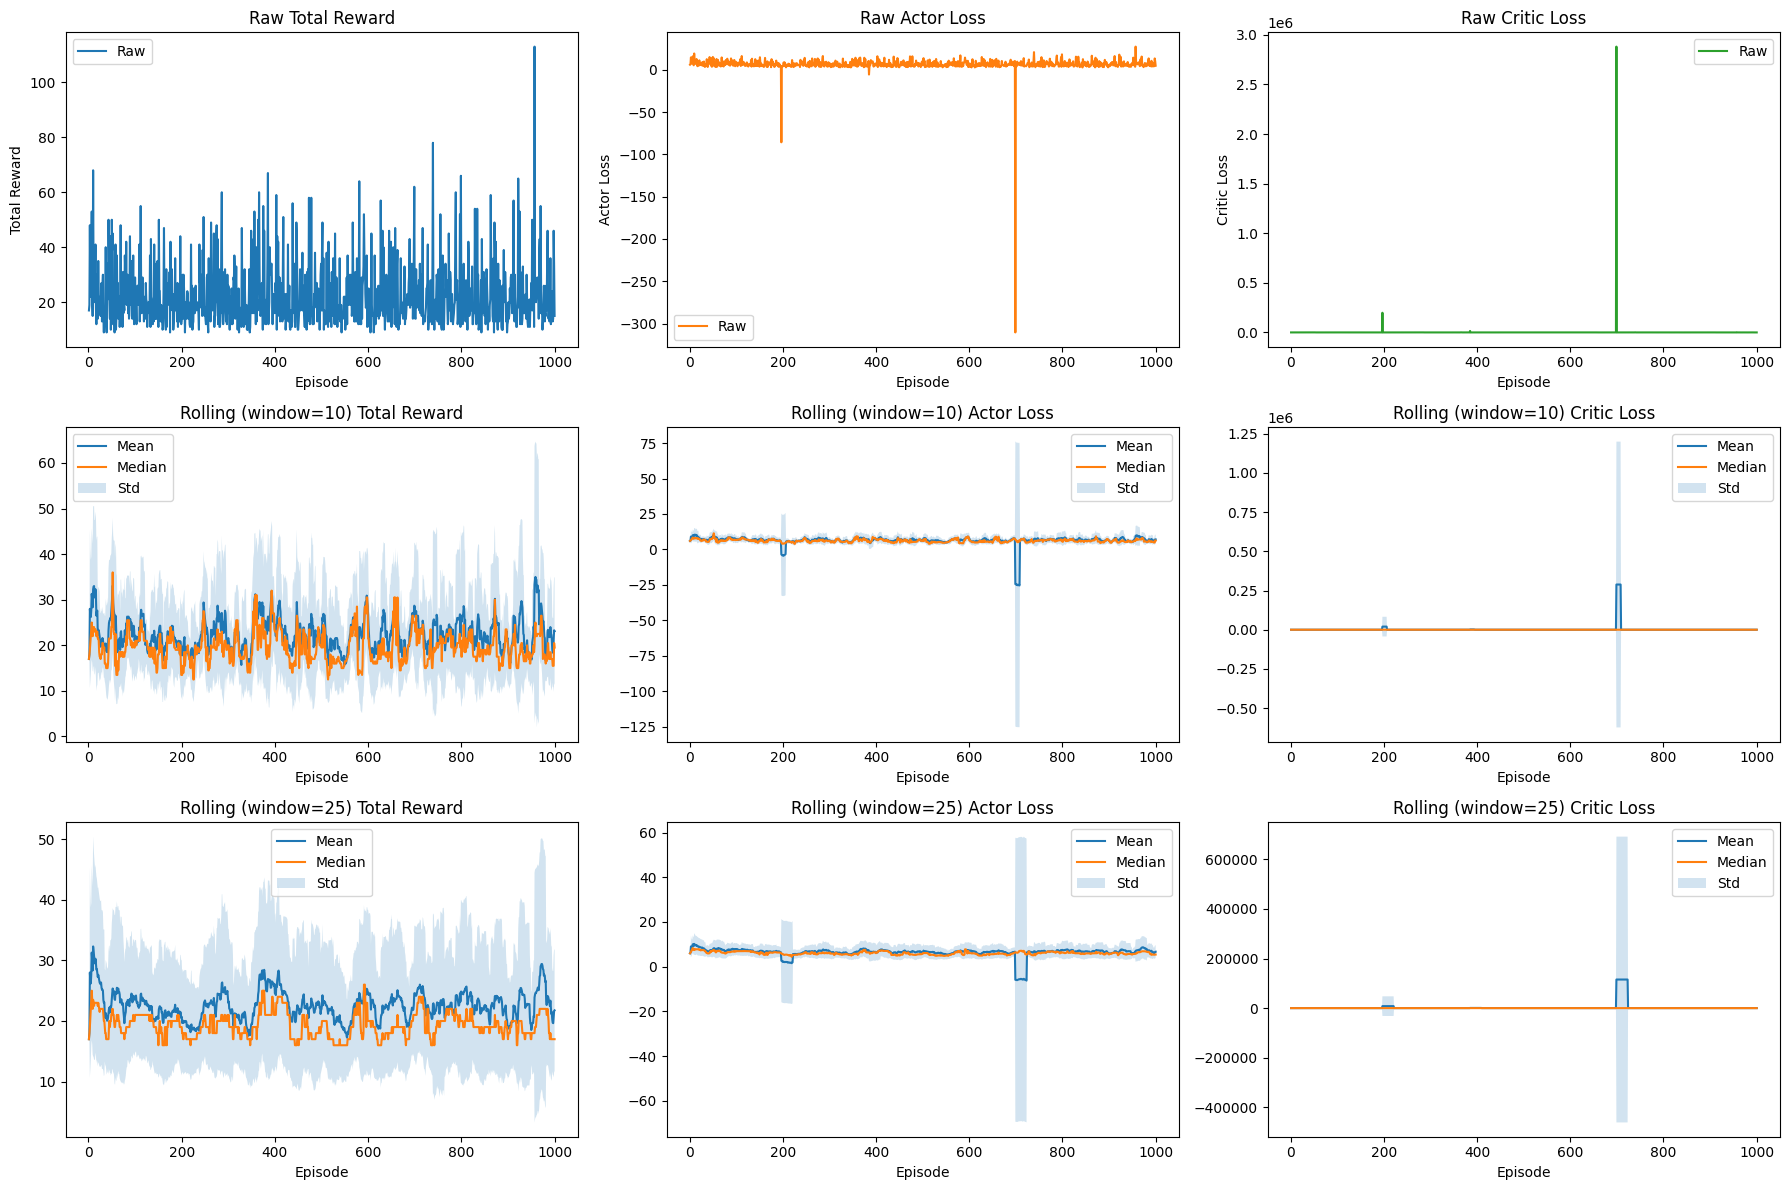

In [ ]:
plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

#### 2.6. Gradient clipping, entropy regularization and rewards clipping

Another strategy is to add gradient clipping so the gradients may not explode this way. We also add another regularization term based on the entropy to encourage exploration as well as normalizing the rewards for stability.

In [ ]:
# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor = 1e-4, l2_critic = 1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """

    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    # Regularization coefficients for actor and critic.
    lambda_actor = l2_actor
    lambda_critic = l2_critic

    # Loop for each episode.
    for episode in range(1, num_episodes + 1):

        # Initialize episode.
        state, _ = env.reset()
        done = False

        states = []
        actions = []
        rewards = []

        actor_hidden_states = None
        critic_hidden_states = None

        # Collect trajectory.
        while not done:
            # Take action using the actor network.
            action, _, _ = agent.select_action(state, actor_hidden_states, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # Compute discounted returns and convert to tensor.
        rewards = np.clip(rewards, -1, 1)
        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        # --- Actor update ---
        with tf.GradientTape() as tape_actor:
            log_probs = []
            actor_hidden_state = None

            # Re-run actor forward pass for each state.
            for s, a in zip(states, actions):
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)  # shape: (1, input_dim)
                s_tensor = tf.expand_dims(s_tensor, axis=1)   # shape: (1, 1, input_dim)
                probs, actor_hidden_state = agent.actor(s_tensor, hidden_states=actor_hidden_state, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            # Re-run critic forward pass for advantage computation.
            critic_hidden_state = None
            values = []
            for s in states:
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, critic_hidden_state = agent.critic(s_tensor, hidden_states=critic_hidden_state, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            advantage = returns - values

            # Standard actor loss.
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))

            # L2 regularization on actor weights
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

            # Entropy regularization
            entropy = -tf.reduce_sum(probs * tf.math.log(probs + 1e-10), axis=-1)
            actor_loss += 0.01 * tf.reduce_mean(entropy)

        # Compute gradients and update actor parameters.
        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        actor_grads = [tf.clip_by_value(grad, -1, 1) for grad in actor_grads]
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        # --- Critic update ---
        with tf.GradientTape() as tape_critic:
            critic_hidden_state = None
            values = []
            for s in states:
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, critic_hidden_state = agent.critic(s_tensor, hidden_states=critic_hidden_state, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            critic_loss = tf.reduce_mean(tf.square(returns - values))

            # L2 regularization on critic weights
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        # Compute gradients and update critic parameters.
        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        critic_grads = [tf.clip_by_value(grad, -1, 1) for grad in critic_grads]
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        # Progress report.
        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

        # Record metrics.
        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

    # Return the training metrics.
    return total_rewards_history, actor_loss_history, critic_loss_history

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # Configuration parameters
    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "noisy_input": False,
        "noise_std": 0.05,
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "num_episodes": 1000,
        "gamma": 0.99,
        "activation_func": tf.nn.relu,
        "actor_connection_prob": 0.1,
        "critic_connection_prob": 1.0
    }

    # Initialize agent with the configuration
    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        noisy_input=config["noisy_input"],
        noise_std=config["noise_std"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        activation_func=config["activation_func"],
        actor_connection_prob=config["actor_connection_prob"],
        critic_connection_prob=config["critic_connection_prob"]
    )

    # Start training
    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(env,
                                                                                 agent,
                                                                                 num_episodes=config["num_episodes"],
                                                                                 gamma=config["gamma"],
                                                                                 l2_actor = 0.001,
                                                                                 l2_critic = 0.001)

Episode 10	Total Reward: 27.00	Actor Loss: 8.9544	Critic Loss: 211.4826
Episode 20	Total Reward: 23.00	Actor Loss: 7.8148	Critic Loss: 159.4579
Episode 30	Total Reward: 33.00	Actor Loss: 10.6904	Critic Loss: 299.5658
Episode 40	Total Reward: 27.00	Actor Loss: 8.9493	Critic Loss: 209.7231
Episode 50	Total Reward: 19.00	Actor Loss: 6.5170	Critic Loss: 111.8470
Episode 60	Total Reward: 26.00	Actor Loss: 8.6289	Critic Loss: 195.4443
Episode 70	Total Reward: 36.00	Actor Loss: 11.4230	Critic Loss: 344.2967
Episode 80	Total Reward: 11.00	Actor Loss: 3.9442	Critic Loss: 41.2820
Episode 90	Total Reward: 16.00	Actor Loss: 5.5601	Critic Loss: 81.7396
Episode 100	Total Reward: 16.00	Actor Loss: 5.5069	Critic Loss: 81.0892
Episode 110	Total Reward: 27.00	Actor Loss: 8.7492	Critic Loss: 207.5194
Episode 120	Total Reward: 22.00	Actor Loss: 7.3276	Critic Loss: 143.1292
Episode 130	Total Reward: 14.00	Actor Loss: 4.8298	Critic Loss: 63.2001
Episode 140	Total Reward: 19.00	Actor Loss: 6.4036	Critic Loss

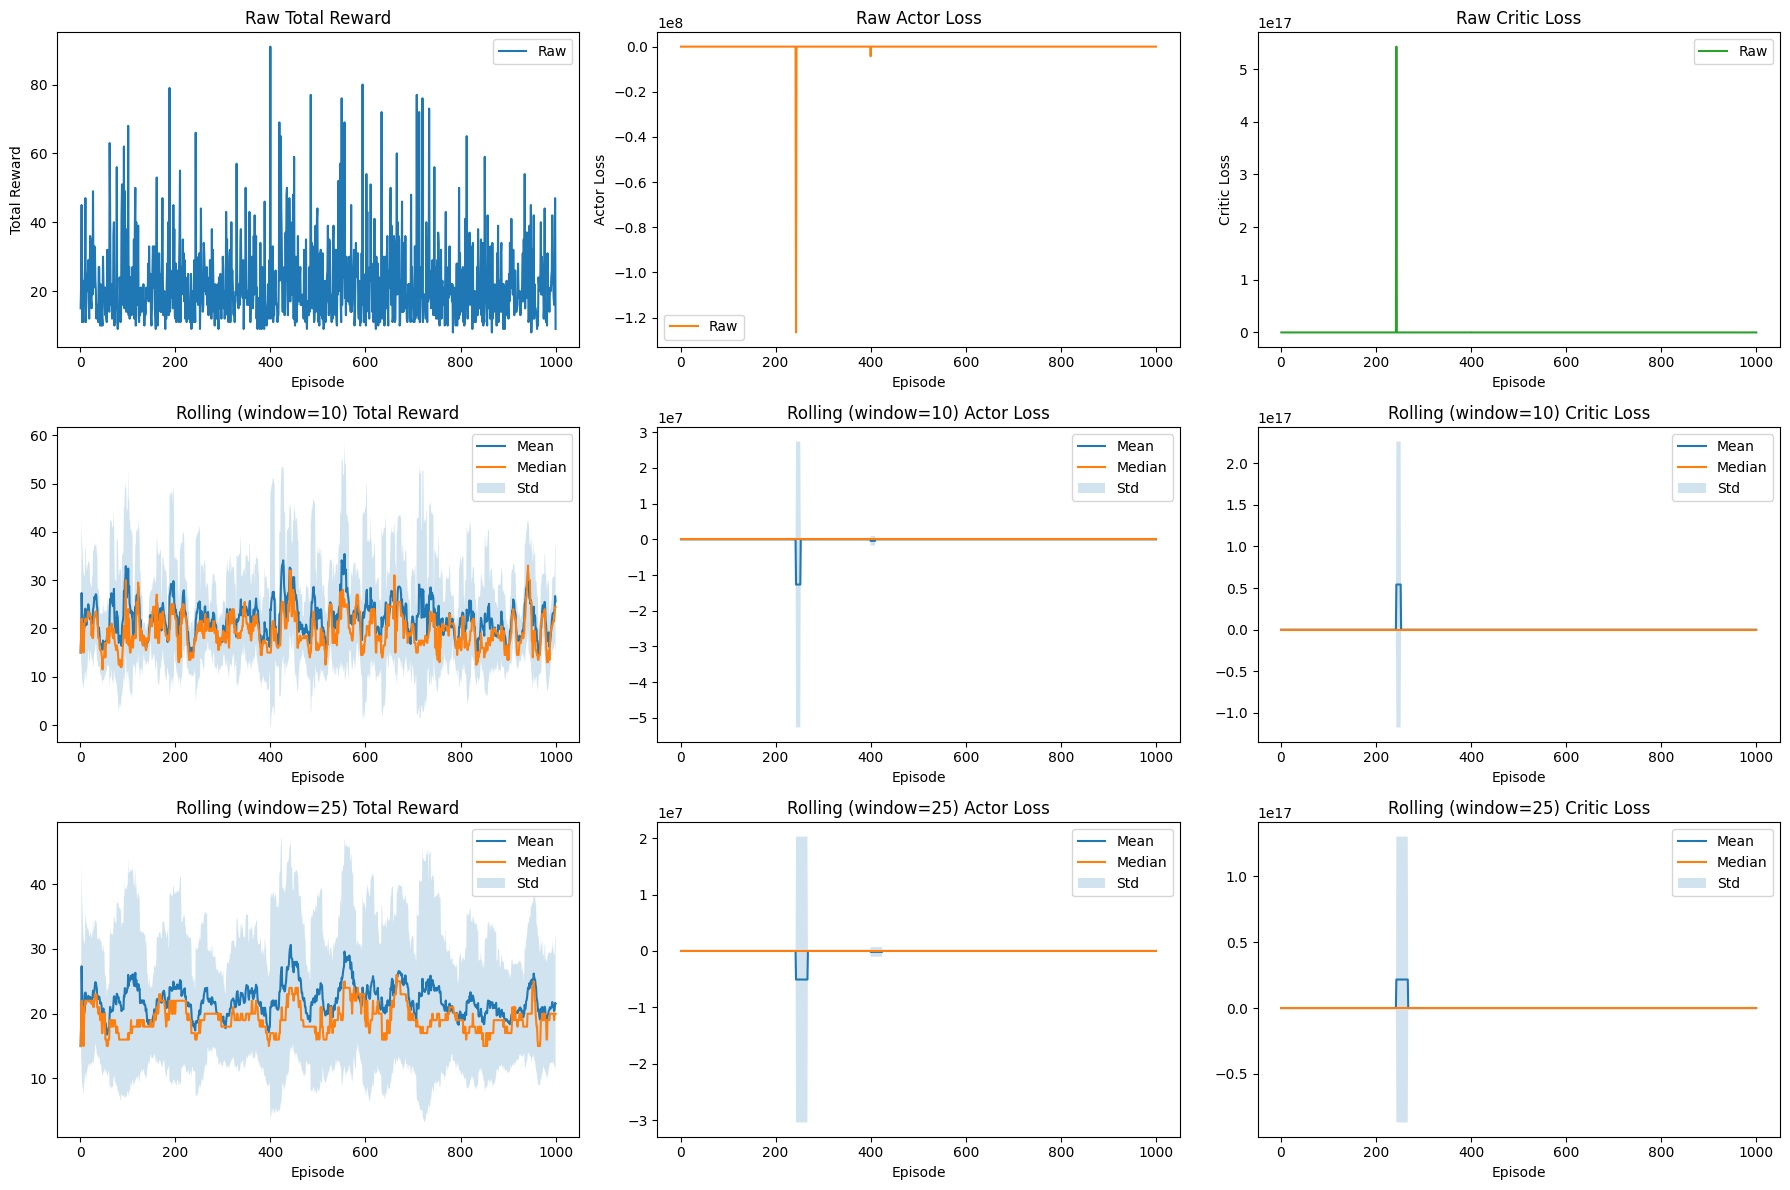

In [ ]:
plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)